In [566]:
### import libraries

import librosa
import numpy as np

In [567]:
### define frame-related constants

Fs = 16000
frame_length = 0.01
frame_shift = 0.01
frame_size = int(frame_length * Fs)
frame_shift_size = int(frame_shift * Fs)

In [568]:
def pre_emphasis(signal, alpha=0.97):
    """
    Applies a pre-emphasis filter to the signal.

    Args:
        signal: The input signal.
        alpha: The pre-emphasis coefficient.

    Returns:
        The pre-emphasized signal.
    """
    #for i in range(1, len(signal)):
    #    signal[i] -= alpha * signal[i - 1]
    #return signal
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])
    
def noise_addition(signal, epsilon=1e-3):
    """
    Adds white noise to the signal.

    Args:
        signal: The input signal.
        epsilon: The noise coefficient.

    Returns:
        The signal with added noise.
    """
    return signal + epsilon * np.random.randn()

def autocorrelation(signal):
    """
    Calculates the autocorrelation of the signal.

    Args:
        signal: The input signal.

    Returns:
        The autocorrelation coefficients.
    """
    r = np.zeros(len(signal))
    for k in range(len(signal)):
        for i in range(len(signal) - k):
            r[k] += signal[i] * signal[i + k]
    return r

def lpc_coefficients(signal, order=10):
    """
    Calculates the LPC coefficients of the signal.

    Args:
        signal: The input signal.
        order: The order of the LPC model.

    Returns:
        The LPC coefficients.
    """
    signal = signal * np.hamming(len(signal))
    r = librosa.lpc(signal, order=order)
    return r
    
def deemphasize(signal):
    """
    Applies a deemphasis filter to the signal.

    Args:
        signal: The input signal.

    Returns:
        The deemphasized signal.
    """
    return np.append(signal[0], signal[1:] + signal[:-1])

def SNR(signal, approximated_signal):
    """
    Calculates the SNR of the signal.

    Args:
        signal: The input signal.
        approximated_signal: The approximated signal.

    Returns:
        The SNR.
    """
    return 10 * np.log10(np.sum(signal ** 2) / np.sum((signal - approximated_signal) ** 2))

In [569]:
import numpy as np
from scipy.signal import lfilter

def decode(a, excitation, order=16):
    """
    Decodes the signal using LPC.

    Args:
        a: The encoded signal.
        excitation: The excitation signal.
        order: The order of the LPC model.

    Returns:
        The decoded signal.
    """

    # Create a signal of zeros with the same length as the encoded signal.
    signal = np.zeros(len(a))

    # Fill the signal with the encoded coefficients.
    for k in range(len(a)):
        signal[k] = a[k]

    # Filter the signal with the LPC coefficients.
    signal = lfilter([1], a, signal)

    # Add the excitation signal.
    signal += excitation

    # Return the decoded signal.
    return signal

In [573]:
signal, Fs = librosa.load('test.wav', sr=None)

### divide the signal into frames
n_frames = int(np.ceil(len(signal) / frame_shift_size))
frames = np.zeros((n_frames, frame_size))
for i in range(n_frames):
    frame = np.zeros(frame_size)
    start = i * frame_shift_size
    end = min(len(signal), start + frame_size)
    frame[:end - start] = signal[start:end]
    frames[i] = frame

### apply preemphasis and noise addition
for i in range(n_frames):
    frames[i] = pre_emphasis(frames[i])
    frames[i] = noise_addition(frames[i])

### create a matrix of LPC coefficients
order = 10
coefficients = np.zeros((n_frames, order))
coefficients[0] = lpc_coefficients(frames[0], order)[1:]
for i in range(2, n_frames):
    # combine the current frame with the previous frame
    f1 = frames[i - 1]
    f2 = frames[i]
    f = np.append(f1, f2)
    f = np.hamming(len(f)) * f
    coefficients[i] = lpc_coefficients(f, order)[1:]

### encode the signal using LPC
excitation = np.zeros((n_frames, frame_size))
for i in range(n_frames):
    e = np.convolve(coefficients[i], frames[i], mode='same')
    excitation[i] = e
    
### decode the signal using the lpc coefficients and the original framed signal
decoded = np.zeros((n_frames, frame_size))
for i in range(n_frames):
    d = np.convolve(coefficients[i], excitation[i], mode='same')
    decoded[i] = d
    
#decoded = np.zeros((n_frames, frame_size))
#for i in range(n_frames):
#    d = decode(coefficients[i], excitation[i], order=order)
#    decoded[i] = d

### deemphasize the signal
decoded = decoded.flatten()
decoded = deemphasize(decoded)
decoded = decoded[:len(signal)]

### detect divergence and correct it
for i in range(len(decoded)):
    if np.abs(decoded[i]) > 0.05:
        decoded[i] = decoded[i-1]

### calculate the SNR
res = SNR(signal, decoded)
print('SNR =', res)

### write the decoded signal to a file
import scipy.io.wavfile
scipy.io.wavfile.write('decoded.wav', Fs, decoded)


SNR = -2.0089330478719


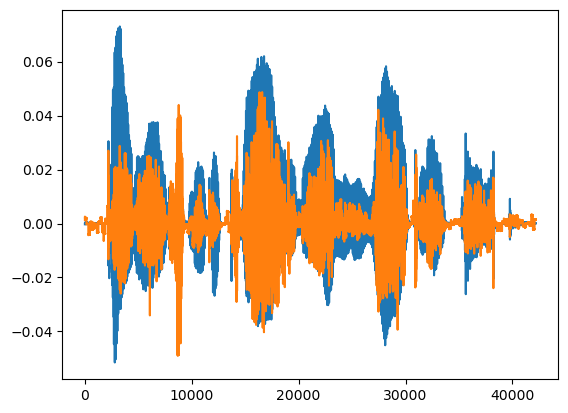

In [574]:
import matplotlib.pyplot as plt
plt.plot(signal)
plt.plot(decoded)

In [577]:
print(coefficients)

[[-0.59190173 -0.24831245  0.19433049 ... -0.05053699  0.18086534
   0.11189661]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.90937274 -0.11913949  0.08909855 ...  0.15116291 -0.13878943
   0.07514264]
 ...
 [-0.8899328  -0.13063632  0.02446326 ...  0.04692463  0.01751626
  -0.0143183 ]
 [-0.90126796 -0.1335931   0.05610215 ...  0.02223575 -0.00633577
   0.02273494]
 [-0.86839935 -0.15672532  0.07653852 ...  0.07711874 -0.11658416
   0.11041811]]
